# 앙상블 학습 

여러개의 분류 모델을 사용하여 보다 정확한 최종 예측을 도출하는 기법. 정형데이터 분류시 앙상블이 뛰어난 성능을 나타냄.

`랜덤 포레스트`,`그래디언트 부스팅 알고리즘`,`XGBoost`, `LightGBM` 등이 있다.

## 앙상블 학습 유형
### 보팅(voting)
여러개의 분류기가 최종 예측 결과를 결정하는 방식. 보팅은 서로 다른 알고리즘의 분류기를 결정하는 방식.

### 배깅(baggging)
배깅의 경우 각각의 분류기가 모두 같은 유형의 알고리즘이지만 데이터 샘플링을 서로 다르게 가져가면서 학습 수행해 보팅을 수행하는 것으로 데이터를 샘플링해서 추출하는 방식을 부스트래핑 분할 방식이라고 한다. 주로 결정 트리 알고리즘을 기반으로 한다.
대표적으로 `랜덤 포레스트`가 이에 해당한다.

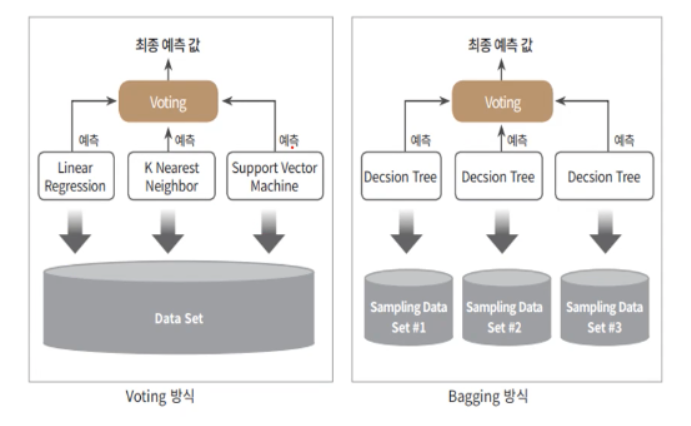

### 부스팅(boosting)
여러개의 분류기가 순차적으로 학습을 수행하고 앞선 분류기가 예측이 틀린 데이터에 대해 다음 분류기에서 가중치를 부여하며 학습과 예측을 진행한다. 예측 성능이 뛰어나다는 특징 有. `그래디언트 부스팅 알고리즘`,`XGBoost`, `LightGBM` 등이 있다.


------------------------------------------------------------------------------------------------------------------------------

# 보팅 유형

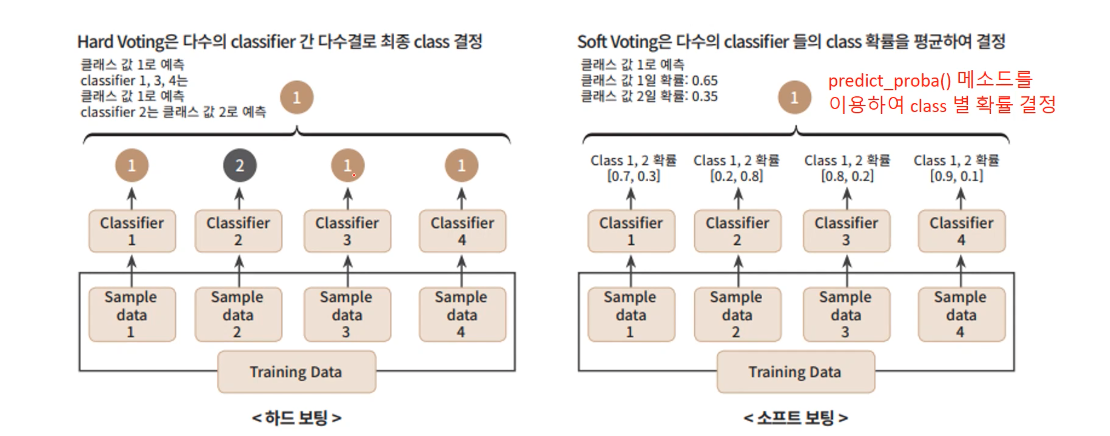
* `하드 보팅`: 다수결
* `소프트 보팅`: 확률의 평균

# 보팅 분류기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [4]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting = 'soft')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

In [8]:
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

Voting 분류기 정확도: 0.9561


In [9]:
# 개별 분류기의 학습/예측/평가


classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


### 앙상블 기법이 전반적으로 단일 알고리즘보다 예측 성능이 뛰어난 경우가 많다.

---------------------------------------------------------------------------------------------------

# 배깅
# 랜덤 포레스트

* ### 특징

앙상블 학습 중 가장 안정적이며 빠른 수행속도를 가지고 있다. 결정트리를 랜덤하게 생성하여 숲을 만든다.

* `부트스트랩 샘플`

결정 트리를 만들기위해 훈련 세트를 랜덤하게 추출하여 새로운 훈련세트를 만드는데 `중복 랜덤 추출`로 n은 훈련세트의 개수와 같다.

- 사이킷런의 랜덤 포레스트는 전체 특성 중 일부 특성을 무작위로 선정해 최선의 분할을 찾음.

전체 특성이 4개라면 2개를 랜덤 추출. 전체 개수의 제곱근 만큼 사용한다.

* 기본적으로 100개의 결정 트리를 훈련하여 훈련세트의 과대적합을 막는데 좋다.

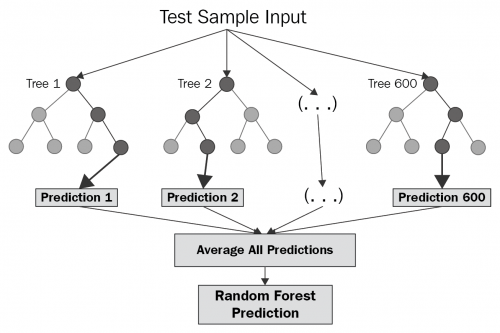

In [12]:
wine = pd.read_csv("https://bit.ly/wine_csv_data")

data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

train_input , test_input, train_target, test_target = train_test_split(data,
                                                                      target, test_size = 0.2,
                                                                      random_state = 42)

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [14]:
# n_jobs  = -1 로 설정해 모든 CPU를 활용하여 병렬로 교차 검증 수행

rf = RandomForestClassifier(n_jobs = -1, random_state = 42) 

In [15]:
scores = cross_validate(rf, train_input, train_target,
                       return_train_score =True, 
                       n_jobs =-1)

print(np.mean(scores['train_score']))
print(np.mean(scores['test_score']))
print("훈련 세트에 과대 적합된 것을 확인해 볼 수 있음")

0.9973541965122431
0.8905151032797809
훈련 세트에 과대 적합된 것을 확인해 볼 수 있음


In [17]:
rf.fit(train_input, train_target)
rf.feature_importances_ # 특성이 예측에서의 중요도를 리턴

array([0.23167441, 0.50039841, 0.26792718])

In [18]:
prediction = rf.predict(test_input)
accuracy = accuracy_score(test_target, prediction)

In [20]:
print("랜덤포레스트 예측 정확도: ", accuracy)

랜덤포레스트 예측 정확도:  0.8892307692307693


# 하이퍼 파라미터 튜닝 

### 랜덤 포레스트 모델의 하이퍼 파라미터

트리 기반 앙상블 알고리즘의 단점 = 하이퍼 파라미터가 많아 튜닝에 많은 시간이 소요된다.

* `n_estimators`: 결정 트리의 개수 디폴트는 10
* `max_feature`: 기본은 'sqrt'  
* `max_depth`

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

In [24]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
# cv = 교차검증의 개수

grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9429


In [25]:
# 찾은 최적을 가지고 모델 학습

rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9386


# 부스팅 알고리즘

약한 학습기를 순차적으로 학습 예측하면서 가중치 부여를 통해 오류를 개선해나가는 방식

# GBM(Gradient Boosting Machine)

경사 하강법을 이용해 가중치를 업데이트하는 알고리즘으로 랜덤 포레스트에 비해 대체로 성능이 조금 낫지만 수행시간이 오래걸린다는 단점이 있다.

* ### `경사 하강법`

오류(손실)를 최소하 하는 방향으로 반복적으로 가중치 업데이트하는 방식 



### GBM의 하이퍼 파라미터

* `loss`
* `learning rate`
* `n_estimators`: 약한 학습기의 개수. 기본값은 100
* `subsample`: 약한 학습기가 학습에 사용할 데이터의 샘플링 비율. 과적합이 우려될때 1보다(전체보다) 작은 값을 설정한다

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')


# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(train_input , train_target)
gb_pred = gb_clf.predict(test_input)
gb_accuracy = accuracy_score(test_target, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.8669
GBM 수행 시간: 0.3 초 
